# Chapter 3

This notebook creates all tables and plots used in Chapter 3 of the dissertation.

In [3]:
### Import libraries

import os
import re
import json
import string
import calendar
import numpy as np
import pandas as pd
from pywaffle import Waffle
from wordcloud import WordCloud
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import warnings
warnings.filterwarnings('ignore')

In [4]:
### Define constants

PATH_PARQUET = 'parquet/'
PATH_SQL = 'sql/'
PATH_JSON = 'json/'

FIG_WIDTH = 16
FIG_HEIGHT = 6

PLOT_CONFIG = {'title': 18,
              'subtitle': 16,
              'label': 14,
              'tick': 12,
              'legend': 12}

In [5]:
### Define functions

def file_exists(filename: str, directory: str = PATH_PARQUET):
    
    pwd = os.getcwd()
    path = os.path.join(pwd, directory, filename)
    
    return os.path.isfile(path);

def generate_string_connection():
    
    # Retrieve params from env
    DB_HOST = os.environ['DB_HOST_STAGE']
    DB_NAME = os.environ['DB_NAME_STAGE']
    DB_PORT = os.environ['DB_PORT_STAGE']
    DB_USERNAME = os.environ['DB_USERNAME_STAGE']
    DB_PASSWORD = os.environ['DB_PASSWORD_STAGE']
    
    # Create string
    string_conn = f'mysql+pymysql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    
    return string_conn;

def sql_to_parquet(query: str, str_conn: str, filename: str, directory: str = PATH_PARQUET):
    
    sqlEngine = create_engine(str_conn)
    dbConnection = sqlEngine.connect()
    
    pwd = os.getcwd()
    path = os.path.join(pwd, directory, filename)
    
    try:
        # Read from database
        df = pd.read_sql(query, dbConnection)
        print('Query successfully executed.')
        
        # Save file
        df.to_parquet(f'{path}.parquet', index = False)
        print(f'Data stored in parquet format in file {filename}.parquet')
        
        return df;

    except Exception as ex:   
        print(ex)

    finally:
        dbConnection.close();
        
def load_data(filename: str, query_file: str, directory_file: str = PATH_PARQUET, directory_query: str = PATH_SQL):
    
    # Define paths
    pwd = os.getcwd()
    filename_ext = filename + '.parquet'
    path_file = os.path.join(pwd, directory_file, filename_ext)
    
    # Check file
    file_exists_bool = file_exists(filename_ext, directory_file)
    
    if file_exists_bool:
        df = pd.read_parquet(path_file)
        print('File retrieved from directory.')
        
    else:
        
        print('File not found. Downloading data.')
        
        # Define query path
        str_conn = generate_string_connection()
        query_file = os.path.join(pwd, directory_query, query_file)
        
        # Read query
        with open(query_file, 'r') as F:
            sql_query = F.read()
            
        # Extract data and save
        df = sql_to_parquet(sql_query, str_conn, filename, directory_file)
        
    return df;

def plot_stackplot(df, COL, ax, OTHER = True, NORMALISE = False):

    df_dist = df[[COL, 'qnt_ingredients', 'colour']].groupby([COL, 'colour'], as_index = False).sum()
    df_dist['dist'] = np.round(df_dist['qnt_ingredients'] / df_dist['qnt_ingredients'].sum(), 5)
    df_dist['order'] = df_dist['qnt_ingredients']

    df_dist.loc[(df_dist[COL].str.lower() == 'other') & OTHER, 'order'] = 0
    df_dist.sort_values(by = 'order', ascending = False, inplace = True)

    ORDER = df_dist[COL].to_list()
    COLOURS = df_dist['colour'].to_list()

    # Sumarised data
    df_dist_plot = pd.pivot_table(data = df,
                                    index = 'cutoff_date',
                                    columns = COL,
                                    values = 'qnt_ingredients',
                                    aggfunc = 'sum')

    df_dist_plot.fillna(0, inplace = True)
    df_dist_plot = df_dist_plot[ORDER]

    if NORMALISE:
        df_dist_plot['total'] = df_dist_plot.sum(axis = 1)
        for i in ORDER:
            df_dist_plot[i] = df_dist_plot[i] * 100.0 / df_dist_plot['total']

        df_dist_plot.drop(columns = 'total', inplace = True)

    df_dist_plot.plot.area(ax = ax,
                          color = COLOURS,
                          legend = None)
    
    if NORMALISE:
        
        yticks = mticker.FormatStrFormatter('%.0f%%')
        ax.yaxis.set_major_formatter(yticks)
    
    return df_dist;

def plot_formatting(ax, parameters, config = PLOT_CONFIG, ignore_ticks = False, has_legend = False):
    
    # Set labels
    ax.set_xlabel(parameters['x_label'], fontsize = config['label'])
    ax.set_ylabel(parameters['y_label'], fontsize = config['label'])
    
    # Set title
    if('title' in parameters.keys()):
        ax.set_title(parameters['title'], fontsize = config['title'])
        
    # Set subtitle
    if('subtitle' in parameters.keys()):
        ax.set_title(parameters['subtitle'], fontsize = config['subtitle'])
    
    # Set tick size
    if(not ignore_ticks):
        ax.tick_params(axis = 'both', which = 'major', labelsize = config['tick'])
    
    # Set legend
    if(has_legend):
        ax.legend(loc = 'best', fontsize = config['legend'])

## Section 3.1

### Why raw ingredeints?

In [6]:
### Load ingredient data

df_timeEvolution = load_data('time_evolution', 'cube_ingredient_evolution.sql')

File retrieved from directory.


In [7]:
### Add grouping and summarise

df_timeEvolution_processed = df_timeEvolution.dropna()

# Remove May 2022
df_timeEvolution_processed = df_timeEvolution_processed[df_timeEvolution_processed['yearmonth'] <= 202204]

df_timeEvolution_categories = df_timeEvolution_processed[['category_id', 'ingredient_count']].groupby('category_id', as_index = False).sum()
df_timeEvolution_categories = df_timeEvolution_categories.sort_values(by = 'ingredient_count', ascending = False).head(5)

df_timeEvolution_processed['category_top'] = df_timeEvolution_processed['category']
df_timeEvolution_processed.loc[-(df_timeEvolution_processed['category_id'].isin(df_timeEvolution_categories['category_id'])), 'category_top'] = 'Other'

# Group per origin
GROUPED_CATEGORIES = {'raw': [102, 103, 107, 101, 148, 108, 109, 153, 110, 113, 105, 106, 104, 112],
                     'beverages': [141, 115, 149, 116, 119, 117, 114, 140, 124, 120, 122]}

GROUPED_CATEGORIES['processed'] = [i for i in df_timeEvolution_processed['category_id'].unique() if(i not in GROUPED_CATEGORIES['raw'] and i not in GROUPED_CATEGORIES['beverages'])]

GROUPED_CATEGORIES_INV = {y: x for x, CATS in GROUPED_CATEGORIES.items() for y in CATS}

df_timeEvolution_processed['category_family'] = df_timeEvolution_processed['category_id'].map(GROUPED_CATEGORIES_INV)

# Format date
df_timeEvolution_processed['cutoff_date'] = df_timeEvolution_processed['yearmonth'] * 100 + 1
df_timeEvolution_processed['cutoff_date'] = pd.to_datetime(df_timeEvolution_processed['cutoff_date'], format = '%Y%m%d')
df_timeEvolution_processed['month_num'] = df_timeEvolution_processed['cutoff_date'].dt.month
df_timeEvolution_processed['month'] = df_timeEvolution_processed['month_num'].apply(lambda x: calendar.month_abbr[x])
df_timeEvolution_processed['year'] = df_timeEvolution_processed['cutoff_date'].dt.year
df_timeEvolution_processed['year_str'] = df_timeEvolution_processed['year'].apply(str)
df_timeEvolution_processed['month_axis'] = df_timeEvolution_processed['month'] + '-' + df_timeEvolution_processed['year_str'].str[2:4]

df_timeEvolution_processed.rename(columns = {'ingredient_count': 'qnt_ingredients'}, inplace = True)

In [8]:
### Create dfs for plot

TOP_CATEGORIES_COLOURS = {'Meat & Poultry': '#f0d06b',
                         'Prepared Foods/Meals': '#d95a40',
                         'Vegetables': '#bf2742',
                         'Cold Beverages': '#501e31',
                         'Desserts': '#577c80',
                         'Other': '#888888'}

GROUPED_CATEGORIES_COLOURS = {'raw': '#0488c2',
                             'beverages': '#03a086',
                             'processed': '#f7d40c'}

df_timeEvolution_top = df_timeEvolution_processed[['cutoff_date', 'category_top', 'qnt_ingredients', 'month_axis']]
df_timeEvolution_top['colour'] = df_timeEvolution_top['category_top'].map(TOP_CATEGORIES_COLOURS)

df_timeEvolution_family = df_timeEvolution_processed[['cutoff_date', 'category_family', 'qnt_ingredients', 'month_axis']]
df_timeEvolution_family['colour'] = df_timeEvolution_family['category_family'].map(GROUPED_CATEGORIES_COLOURS)

df_timeEvolution_top_total = df_timeEvolution_top[['category_top', 'qnt_ingredients']].groupby('category_top', as_index = False).sum()
df_timeEvolution_top_total['distribution'] = df_timeEvolution_top_total['qnt_ingredients'] / sum(df_timeEvolution_top_total['qnt_ingredients'])

df_timeEvolution_family_total = df_timeEvolution_family[['category_family', 'qnt_ingredients']].groupby('category_family', as_index = False).sum()
df_timeEvolution_family_total['distribution'] = df_timeEvolution_family_total['qnt_ingredients'] / sum(df_timeEvolution_family_total['qnt_ingredients'])

print(df_timeEvolution_top_total.sort_values(by = 'distribution'))
print('')
print(df_timeEvolution_family_total.sort_values(by = 'distribution'))

           category_top  qnt_ingredients  distribution
1              Desserts            13328      0.068130
0        Cold Beverages            14328      0.073241
5            Vegetables            15064      0.077004
2        Meat & Poultry            19154      0.097911
4  Prepared Foods/Meals            19259      0.098448
3                 Other           114494      0.585267

  category_family  qnt_ingredients  distribution
0       beverages            31440      0.160714
2             raw            68599      0.350662
1       processed            95588      0.488624


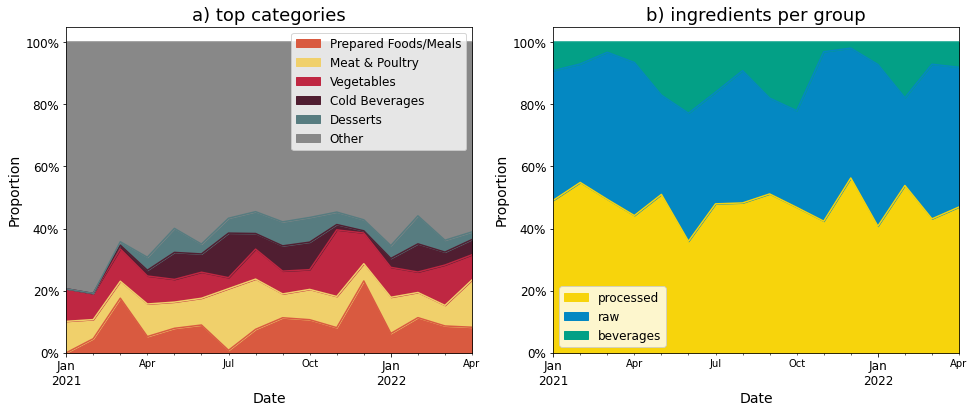

In [9]:
### Plot evolution charts

fig, axs = plt.subplots(1, 2, figsize = (FIG_WIDTH, FIG_HEIGHT)) # Create figure and axes

# Plot top data
df_plot_top_dist = plot_stackplot(df_timeEvolution_top, 'category_top', axs[0], NORMALISE = True)

plot_params = {'title': 'a) top categories',
             'x_label': 'Date',
             'y_label': 'Proportion'}

plot_formatting(axs[0], plot_params, has_legend = True)

# Plot group data
df_plot_top_dist = plot_stackplot(df_timeEvolution_family, 'category_family', axs[1], NORMALISE = True)

plot_params = {'title': 'b) ingredients per group',
             'x_label': 'Date',
             'y_label': 'Proportion'}

plot_formatting(axs[1], plot_params, has_legend = True)

plt.show()

### Variation of properties

In [10]:
### Load ingredient data

df_ingProperties = load_data('raw_ingredient_properties', 'cube_raw_ingredient_properties.sql')

File retrieved from directory.


In [11]:
### Process data for violin plot

NEW_NAMES = {'Meat & Poultry': 'Meats',
            'Vegetables': 'Vegetables',
            'Dairy & Eggs': 'Dairy',
            'Fish & Seafoods': 'Seafood',
            'Fruits': 'Fruits',
            'Oils, Vinegars & Flavourings': 'Oils'}

df_ingProperties_plot = df_ingProperties[['category', 'energy_quantity', 'protein_quantity']]
df_ingProperties_plot['axis'] = df_ingProperties_plot['category'].map(NEW_NAMES)

# Calculate percentiles
tuple_percentiles_energy = tuple(df_ingProperties_plot['energy_quantity'].quantile([0.001, 0.9995]).tolist())
tuple_percentiles_protein = tuple(df_ingProperties_plot['protein_quantity'].quantile([0.01, 0.99]).tolist())

# Create lists per category for biolin plot
LIST_PLOT_ENERGY = [df_ingProperties_plot['energy_quantity'][df_ingProperties_plot['axis'] == J] for J in NEW_NAMES.values()]
LIST_PLOT_PROTEIN = [df_ingProperties_plot['protein_quantity'][df_ingProperties_plot['axis'] == J] for J in NEW_NAMES.values()]

# Remove outliers
LIST_PLOT_ENERGY = [i[i.between(tuple_percentiles_energy[0], tuple_percentiles_energy[1])] for i in LIST_PLOT_ENERGY]
LIST_PLOT_PROTEIN = [i[i.between(tuple_percentiles_protein[0], tuple_percentiles_protein[1])] for i in LIST_PLOT_PROTEIN]

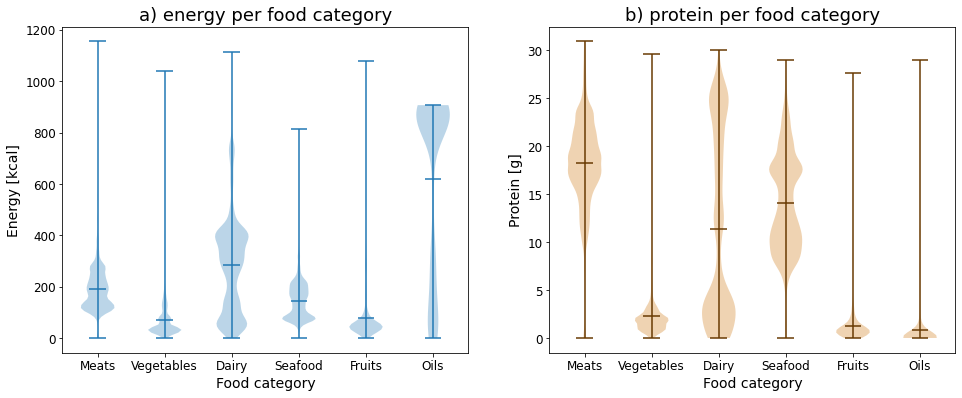

In [12]:
### Violin plots

fig, axs = plt.subplots(1, 2, figsize = (FIG_WIDTH, FIG_HEIGHT)) # Create figure and axes

# Plot energy
axs[0].violinplot(LIST_PLOT_ENERGY, showmeans = True)
axs[0].set_xticks([x + 1 for x in range(len(NEW_NAMES.values()))])
axs[0].set_xticklabels(NEW_NAMES.values())

plot_params = {'title': 'a) energy per food category',
             'x_label': 'Food category',
             'y_label': 'Energy [kcal]'}

plot_formatting(axs[0], plot_params)

# Plot protein
parts = axs[1].violinplot(LIST_PLOT_PROTEIN, showmeans = True)

for pc in parts['bodies']:
    pc.set_facecolor('#cc7000')
    #pc.set_edgecolor('#cc7000')
    
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('#673800')

axs[1].set_xticks([x + 1 for x in range(len(NEW_NAMES.values()))])
axs[1].set_xticklabels(NEW_NAMES.values())

plot_params = {'title': 'b) protein per food category',
             'x_label': 'Food category',
             'y_label': 'Protein [g]'}

plot_formatting(axs[1], plot_params)

plt.show()

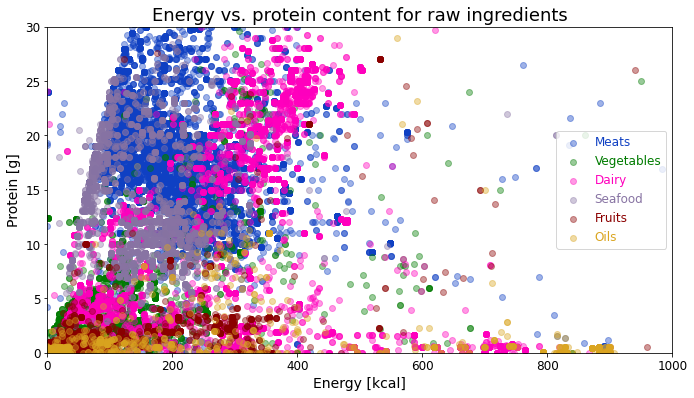

In [14]:
### Scatter plot

COLOUR_NAMES = {'Meat & Poultry': '#0f40c3',
            'Vegetables': '#007b00',
            'Dairy & Eggs': '#ff00bd',
            'Fish & Seafoods': '#8874a3',
            'Fruits': '#8b0000',
            'Oils, Vinegars & Flavourings': '#daa520'}

df_ingProperties_scatter = df_ingProperties[['category', 'energy_quantity', 'protein_quantity']].dropna()

# Plot figure
fig, ax = plt.subplots(1, 1, figsize = (FIG_WIDTH * 0.7, FIG_HEIGHT)) # Create figure and axes

for CAT in COLOUR_NAMES.keys():
    DF_PLOT = df_ingProperties_scatter[df_ingProperties_scatter['category'] == CAT]

    ax.scatter(DF_PLOT['energy_quantity'],
              DF_PLOT['protein_quantity'],
              color = COLOUR_NAMES[CAT],
              label = NEW_NAMES[CAT],
              alpha = 0.4)

# Format plot
ax.set_xlim([0, 1000])
ax.set_ylim([0, 30])

plot_params = {'title': 'Energy vs. protein content for raw ingredients',
             'x_label': 'Energy [kcal]',
             'y_label': 'Protein [g]'}

plot_formatting(ax, plot_params)
ax.legend(loc = 'best', fontsize = PLOT_CONFIG['legend'], labelcolor = COLOUR_NAMES.values())

plt.show()

### Painful text analytics

In [12]:
### Text samples

df_ingProperties.sample(7, random_state = 888)

,ingredient_id,ingredient_name,category,energy_quantity,protein_quantity
20553,883896,Hot & Spicy Chicken Wings,Meat & Poultry,167.0,17.0
14866,803294,Salt and Pepper Seasoning Mix,Meat & Poultry,195.0,2.0
41046,1102659,Prep Premium Lemon Infused Oil,"Oils, Vinegars & Flavourings",824.0,0.0
24422,943734,Bananas 3kg,Fruits,89.0,1.0
30866,1018941,Farmstead Cumberland Sausage 8'S,Meat & Poultry,191.0,16.0
45641,1159248,Frozen Chicken Breast Fillets (5 Pack),Meat & Poultry,106.0,24.0
23213,933295,Bb - Peach Yellow,Fruits,39.0,0.9


In [13]:
### Character count

string_chars = df_ingProperties['ingredient_name'].to_string(index = False)

# Format string
string_chars = string_chars.replace(' ', '')
string_chars = string_chars.lower()

# Separate individual chars
list_chars = [i for i in string_chars]

# Create set of unique chars
set_chars = set(list_chars)

# Build df with char count
dict_chars = {i: list_chars.count(i) for i in set_chars}
df_chars = pd.DataFrame({'char': dict_chars.keys(), 'count': dict_chars.values()})

df_chars['type'] = 'especial'
df_chars.loc[df_chars['char'].str.contains('[a-z]', regex = True), 'type'] = 'letter'
df_chars.loc[df_chars['char'].str.contains('\\d', regex = True), 'type'] = 'number'
df_chars.loc[df_chars['char'].str.startswith('\n'), 'type'] = 'escape'

df_chars_goruped = df_chars[['type', 'count']].groupby('type', as_index = False).sum()
df_chars_goruped['dist'] = df_chars_goruped['count'] / sum(df_chars_goruped['count'])
df_chars_goruped.sort_values(by = 'count', inplace = True)
df_chars_goruped.reset_index(drop = True, inplace = True)

# Dict for special characters
df_chars_special = df_chars[df_chars['type'] == 'especial']
df_chars_special.set_index('char', inplace = True)
dict_chars_special = df_chars_special['count'].to_dict()

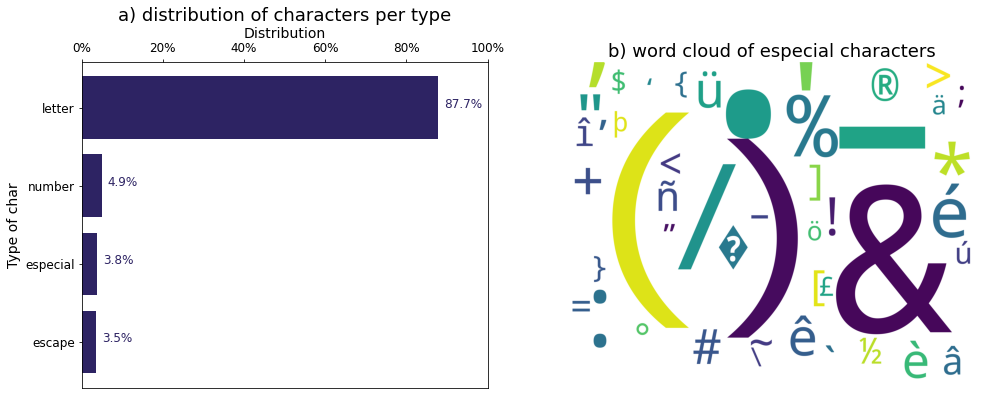

In [14]:
### Plot findings

fig, axs = plt.subplots(1, 2, figsize = (FIG_WIDTH, FIG_HEIGHT)) # Create figure and axes

# Plot distribution chart
axs[0].barh(df_chars_goruped['type'],
           df_chars_goruped['dist'] * 100,
           color = '#2D2363')

# Format plot
plot_params = {'title': 'a) distribution of characters per type',
             'x_label': 'Distribution',
             'y_label': 'Type of char'}

plot_formatting(axs[0], plot_params, has_legend = False, ignore_ticks = True)
axs[0].tick_params(axis = 'y', which = 'major', labelsize = PLOT_CONFIG['tick'])

# Format x axis
axs[0].tick_params(axis = 'x', which = 'major', labelsize = PLOT_CONFIG['tick'],
                  bottom = False, top = True, labelbottom = False, labeltop = True)
axs[0].xaxis.set_label_position('top') 

xticks = mticker.FormatStrFormatter('%.0f%%')
axs[0].xaxis.set_major_formatter(xticks)
axs[0].set_xlim([0, 100])

# Add text
X_POS_DELTA = 0
Y_POS_DELTA = -1.5

for x, y in enumerate(df_chars_goruped['dist']):
    axs[0].text(100 * y - Y_POS_DELTA,
                x - X_POS_DELTA,
                '{:.1%}'.format(y),
                color = '#2D2363',
                fontsize = PLOT_CONFIG['legend'])
    
# Plor wordcloud
wc = WordCloud(background_color = 'white', relative_scaling = 0.22, prefer_horizontal = 1,
               width = 2500, height = 2000, random_state = 444).generate_from_frequencies(dict_chars_special)
axs[1].imshow(wc)

# Format wordcloud
axs[1].set_title('b) word cloud of especial characters', fontsize = PLOT_CONFIG['title'])
axs[1].tick_params(axis = 'both', which = 'major', bottom = False, left = False,
                  labelbottom = False, labelleft = False)

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

plt.show()

In [15]:
### Word count

string_words = df_ingProperties['ingredient_name'].to_string(index = False)
string_words = string_words.lower()
string_words = string_words.replace('\n', ' ') # Remove escape character
string_words = re.sub(' +', ' ', string_words) # Remove multiple white spaces

# Split into a list
list_words = string_words.split(' ')

# Create set of unique chars
set_words = set(list_words)

# Build df with char count
dict_words = {i: list_words.count(i) for i in set_words if len(i) > 1}

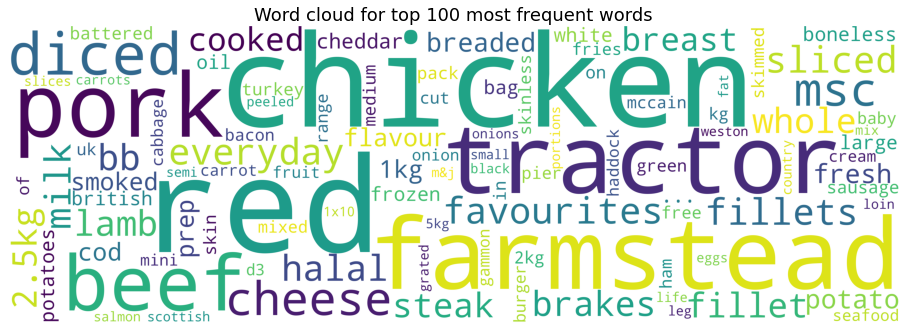

In [16]:
### Build word cloud

fig, ax = plt.subplots(1, 1, figsize = (FIG_WIDTH, FIG_HEIGHT)) # Create figure and axes

# Plor wordcloud
wc = WordCloud(background_color = 'white', relative_scaling = 0.22, max_words = 100,
               width = 6000, height = 2000, random_state = 444).generate_from_frequencies(dict_words)
ax.imshow(wc)

# Format wordcloud
ax.set_title('Word cloud for top 100 most frequent words', fontsize = PLOT_CONFIG['title'])
ax.tick_params(axis = 'both', which = 'major', bottom = False, left = False,
                  labelbottom = False, labelleft = False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

## Section 3.2

In [17]:
### Load file

with open(PATH_JSON + 'robotoff_taxonomy.json', 'r', encoding = 'utf-8') as F:
    dict_robotoff_taxonomy_raw = json.loads(F.read())

In [31]:
### Extract languages

LANGS = {'en': 'English',
        'fr': 'French',
        'it': 'Italian'}

df_taxonomy_languages = pd.Series([i[:2] for i in dict_robotoff_taxonomy_raw.keys()])

df_taxonomy_languages = pd.DataFrame(df_taxonomy_languages.value_counts(normalize = True)).reset_index()
df_taxonomy_languages['lang'] = df_taxonomy_languages['index'].map(LANGS)
df_taxonomy_languages['lang'].fillna('Other', inplace = True)

df_taxonomy_languages = df_taxonomy_languages[['lang', 0]].groupby('lang', as_index = False).sum()
df_taxonomy_languages['count'] = np.round(df_taxonomy_languages[0] * 100)
df_taxonomy_languages['y'] = df_taxonomy_languages[0].map('{:.0%}'.format)

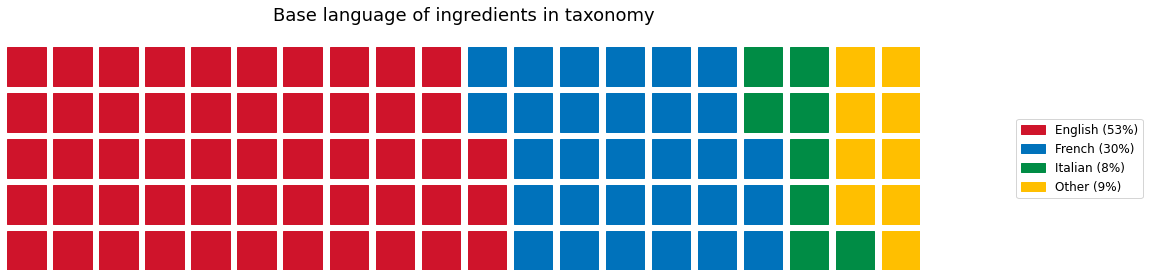

In [43]:
### Plot waffle

Y_COLOURS = ['#cf142b', '#0072bb', '#008C45', '#ffbf00']

fig = plt.figure(
    FigureClass = Waffle,
    values = df_taxonomy_languages['count'],
    labels = ['{0} ({1})'.format(n[0], n[1]) for n in df_taxonomy_languages[['lang', 'y']].itertuples(index = False)],
    legend = {'loc': 'right',
        'bbox_to_anchor': (1.25, 0.5),
        'fontsize': PLOT_CONFIG['legend']},
        title = {'label': 'Base language of ingredients in taxonomy\n',
        'loc': 'center',
        'fontsize': PLOT_CONFIG['title']},
        rows = 5,
        colors = Y_COLOURS,
        figsize = (FIG_WIDTH, FIG_HEIGHT))

fig.show()

In [97]:
### DF with hierarchical distribution

dict_hierarchical_dist = {i: '' for i in dict_robotoff_taxonomy_raw.keys() if i[:2] == 'en'}

for KEY in dict_hierarchical_dist.keys():
    ELEMENT = dict_robotoff_taxonomy_raw[KEY]
    
    has_parent = 'parents' in ELEMENT.keys()
    has_children = 'children' in ELEMENT.keys()
    
    if has_parent & has_children:
        dict_hierarchical_dist[KEY] = 'is both'
        
    elif has_parent:
        dict_hierarchical_dist[KEY] = 'is child only'
        
    elif has_children:
        dict_hierarchical_dist[KEY] = 'is parent only'
        
    else:
        dict_hierarchical_dist[KEY] = 'no relations'
    
df_dict_hierarchical_dist = pd.DataFrame({'ingredient': dict_hierarchical_dist.keys(),
                                         'status': dict_hierarchical_dist.values()})

df_dict_hierarchical_dist_grouped = pd.DataFrame(df_dict_hierarchical_dist['status'].value_counts()).reset_index()
df_dict_hierarchical_dist_grouped['dist'] = df_dict_hierarchical_dist_grouped['status'] / sum(df_dict_hierarchical_dist_grouped['status'])
df_dict_hierarchical_dist_grouped.sort_values(by = 'dist', ascending = True, inplace = True)
df_dict_hierarchical_dist_grouped.reset_index(drop = True, inplace = True)

,ingredient,status
2527,en:artisan-products,is parent only
1108,en:baby-foods,is parent only
1034,en:batches-withdrawn-from-retail-stores,is parent only
1653,en:bee-products,is parent only
801,en:beverages,is parent only
1980,en:biscuits-and-cakes,is parent only
1001,en:breaded-products,is parent only
2943,en:breakfasts,is parent only
3553,en:canned-foods,is parent only
155,en:caviar-substitutes,is parent only


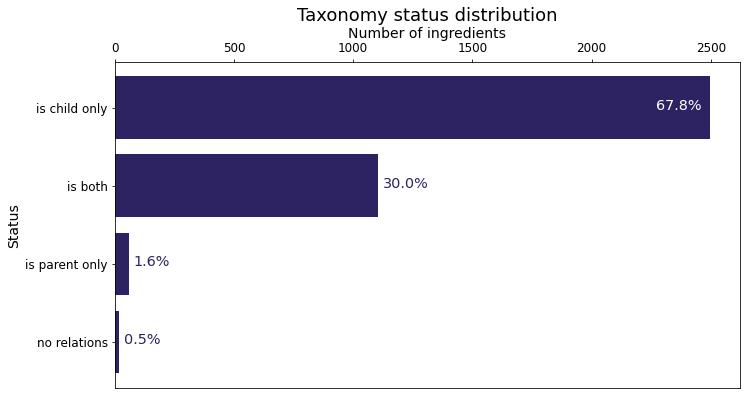

In [100]:
### Plot bars per distribution

ING_COUNT = sum(df_dict_hierarchical_dist_grouped['status'])

fig, ax = plt.subplots(1, 1, figsize = (FIG_WIDTH * 0.7, FIG_HEIGHT)) # Create figure and axes

# Plot distribution chart
ax.barh(df_dict_hierarchical_dist_grouped['index'],
       df_dict_hierarchical_dist_grouped['status'],
       color = '#2D2363')

# Format plot
plot_params = {'title': 'Taxonomy status distribution',
             'x_label': 'Number of ingredients',
             'y_label': 'Status'}

plot_formatting(ax, plot_params, has_legend = False, ignore_ticks = True)
ax.tick_params(axis = 'y', which = 'major', labelsize = PLOT_CONFIG['tick'])

# Format x axis
ax.tick_params(axis = 'x', which = 'major', labelsize = PLOT_CONFIG['tick'],
                bottom = False, top = True, labelbottom = False, labeltop = True)
ax.xaxis.set_label_position('top') 

# Add text
X_POS_DELTA = 0.025
Y_POS_DELTA = -20

for x, y in enumerate(df_dict_hierarchical_dist_grouped['status']):
    if x < 3:
        ax.text(y - Y_POS_DELTA,
                x - X_POS_DELTA,
                '{:.1%}'.format(y / ING_COUNT),
                color = '#2D2363',
                fontsize = PLOT_CONFIG['legend'] * 1.2)
        
    else:
        ax.text(y - 225,
                x - X_POS_DELTA,
                '{:.1%}'.format(y / ING_COUNT),
                color = '#ffffff',
                fontsize = PLOT_CONFIG['legend'] * 1.2)

plt.show()

In [104]:
### Explore small elements

df_dict_hierarchical_dist[df_dict_hierarchical_dist['status'] == 'no relations'].sort_values(by = 'ingredient')
df_dict_hierarchical_dist[df_dict_hierarchical_dist['status'] == 'is parent only'].sort_values(by = 'ingredient')

# df_dict_hierarchical_dist_grouped

,ingredient,status
2527,en:artisan-products,is parent only
1108,en:baby-foods,is parent only
1034,en:batches-withdrawn-from-retail-stores,is parent only
1653,en:bee-products,is parent only
801,en:beverages,is parent only
1980,en:biscuits-and-cakes,is parent only
1001,en:breaded-products,is parent only
2943,en:breakfasts,is parent only
3553,en:canned-foods,is parent only
155,en:caviar-substitutes,is parent only
